In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, txt_file, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        with open(txt_file, 'r') as f:
            self.img_list = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.img_list[idx].split('.')[0]) % 102
        return image, label

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    device = next(model.parameters()).device
    best_val_acc = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            if isinstance(outputs, tuple):
                loss = criterion(outputs[0], labels)
                for aux_output in outputs[1:]:
                    loss += 0.3 * criterion(aux_output, labels)
                outputs = outputs[0]
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validating'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)

        print(f'Train Loss: {epoch_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_acc:.2f}%')

        # Update learning rate
        scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_val_acc,
            }, os.path.join(base_path, 'best_googlenet.pth'))

        # Plot current training curve
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.savefig(os.path.join(base_path, 'loss_curve.png'))
        plt.close()

    return train_losses, val_losses

def evaluate_and_report(model, test_loader, criterion, device, save_path):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall metrics
    test_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    # Generate and save confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(save_path, 'confusion_matrix.png'))
    plt.close()

    # Generate classification report
    report = classification_report(all_labels, all_preds)

    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)

    # Save results to file
    with open(os.path.join(save_path, 'evaluation_results.txt'), 'w') as f:
        f.write(f"Test Loss: {test_loss:.4f}\n")
        f.write(f"Accuracy: {accuracy:.4f}\n\n")
        f.write("Confusion Matrix:\n")
        f.write(str(cm))
        f.write("\n\nClassification Report:\n")
        f.write(report)

In [ ]:
if __name__ == '__main__':
    # Set random seed
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Set paths
    base_path = '/content/drive/MyDrive/ip102_v1.1-001/ip102_v1.1'
    img_dir = os.path.join(base_path, 'images')
    train_txt = os.path.join(base_path, 'train.txt')
    val_txt = os.path.join(base_path, 'val.txt')
    test_txt = os.path.join(base_path, 'test.txt')

    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = CustomDataset(train_txt, img_dir, transform=transform)
    val_dataset = CustomDataset(val_txt, img_dir, transform=transform)
    test_dataset = CustomDataset(test_txt, img_dir, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')

    # Create model
    model = torchvision.models.googlenet(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 102)
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training
    print("Starting training...")
    try:
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler)

        # Load best model and evaluate
        print("\nEvaluating best model...")
        checkpoint = torch.load(os.path.join(base_path, 'best_googlenet.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
        evaluate_and_report(model, test_loader, criterion, device, base_path)

    except Exception as e:
        print(f"Error during execution: {str(e)}")
        import traceback
        traceback.print_exc()

Using device: cuda
Starting training...
Epoch 1/25
Learning Rate: 0.010000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


Train Loss: 4.7368
Validation Loss: 4.7750
Validation Accuracy: 0.00%
Epoch 2/25
Learning Rate: 0.010000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


Train Loss: 4.3503
Validation Loss: 4.7808
Validation Accuracy: 1.00%
Epoch 3/25
Learning Rate: 0.010000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


Train Loss: 3.9307
Validation Loss: 4.8997
Validation Accuracy: 0.00%
Epoch 4/25
Learning Rate: 0.010000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


Train Loss: 3.4113
Validation Loss: 4.9987
Validation Accuracy: 0.50%
Epoch 5/25
Learning Rate: 0.010000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


Train Loss: 2.7799
Validation Loss: 5.0314
Validation Accuracy: 2.00%
Epoch 6/25
Learning Rate: 0.010000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


Train Loss: 2.1609
Validation Loss: 5.2821
Validation Accuracy: 2.00%
Epoch 7/25
Learning Rate: 0.010000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


Train Loss: 1.5867
Validation Loss: 5.5476
Validation Accuracy: 0.50%
Epoch 8/25
Learning Rate: 0.001000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


Train Loss: 1.0133
Validation Loss: 5.5672
Validation Accuracy: 1.00%
Epoch 9/25
Learning Rate: 0.001000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]


Train Loss: 0.8543
Validation Loss: 5.6205
Validation Accuracy: 0.50%
Epoch 10/25
Learning Rate: 0.001000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


Train Loss: 0.7560
Validation Loss: 5.6352
Validation Accuracy: 1.00%
Epoch 11/25
Learning Rate: 0.001000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


Train Loss: 0.7008
Validation Loss: 5.6813
Validation Accuracy: 1.00%
Epoch 12/25
Learning Rate: 0.001000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Train Loss: 0.6612
Validation Loss: 5.7122
Validation Accuracy: 1.00%
Epoch 13/25
Learning Rate: 0.001000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Train Loss: 0.6114
Validation Loss: 5.7309
Validation Accuracy: 1.00%
Epoch 14/25
Learning Rate: 0.001000


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]


Train Loss: 0.5475
Validation Loss: 5.7525
Validation Accuracy: 1.00%
Epoch 15/25
Learning Rate: 0.000100


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Train Loss: 0.5265
Validation Loss: 5.7748
Validation Accuracy: 1.00%
Epoch 16/25
Learning Rate: 0.000100


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Train Loss: 0.5273
Validation Loss: 5.7481
Validation Accuracy: 1.00%
Epoch 17/25
Learning Rate: 0.000100


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


Train Loss: 0.5277
Validation Loss: 5.7665
Validation Accuracy: 1.00%
Epoch 18/25
Learning Rate: 0.000100


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


Train Loss: 0.5265
Validation Loss: 5.7576
Validation Accuracy: 1.50%
Epoch 19/25
Learning Rate: 0.000100


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


Train Loss: 0.5091
Validation Loss: 5.7554
Validation Accuracy: 1.00%
Epoch 20/25
Learning Rate: 0.000100


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


Train Loss: 0.5094
Validation Loss: 5.7552
Validation Accuracy: 1.50%
Epoch 21/25
Learning Rate: 0.000100


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


Train Loss: 0.5094
Validation Loss: 5.7728
Validation Accuracy: 1.50%
Epoch 22/25
Learning Rate: 0.000010


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


Train Loss: 0.5138
Validation Loss: 5.7837
Validation Accuracy: 1.50%
Epoch 23/25
Learning Rate: 0.000010


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Train Loss: 0.5077
Validation Loss: 5.7798
Validation Accuracy: 1.50%
Epoch 24/25
Learning Rate: 0.000010


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]


Train Loss: 0.5172
Validation Loss: 5.7891
Validation Accuracy: 1.50%
Epoch 25/25
Learning Rate: 0.000010


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
<ipython-input-50-471215344f75>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.j

Train Loss: 0.5097
Validation Loss: 5.7639
Validation Accuracy: 1.50%

Evaluating best model...


Testing: 100%|██████████| 13/13 [04:41<00:00, 21.65s/it]



Test Results:
Test Loss: 5.1721
Accuracy: 0.0075

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

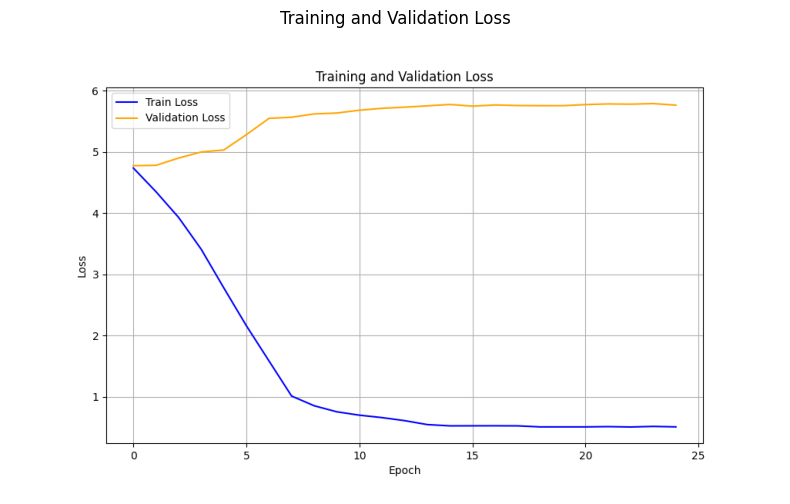

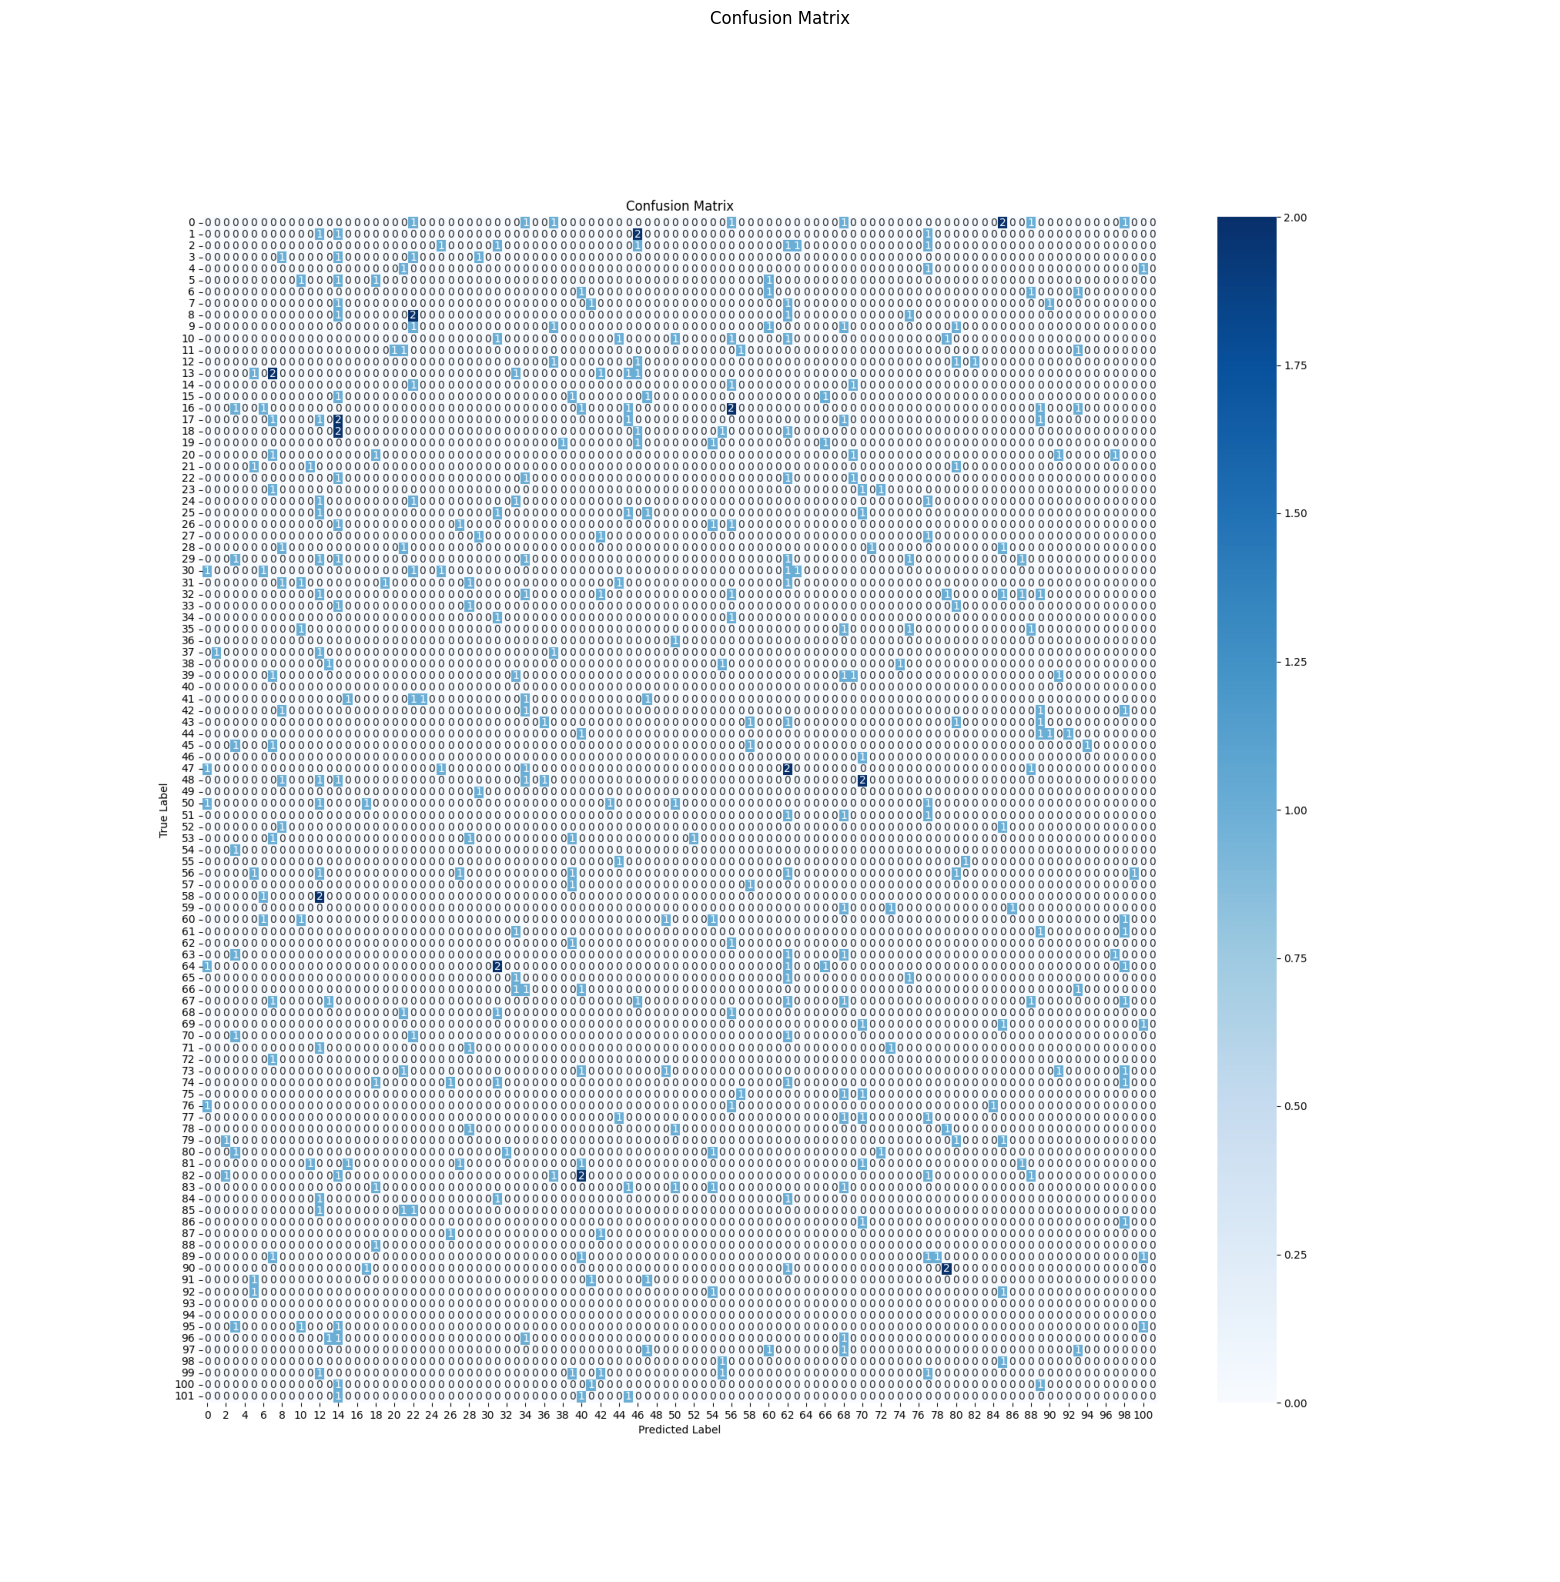

Test Loss: 5.1721
Accuracy: 0.0075

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00  

In [ ]:
# 显示损失曲线
plt.figure(figsize=(12, 6))
img = plt.imread(os.path.join(base_path, 'loss_curve.png'))
plt.imshow(img)
plt.axis('off')
plt.title('Training and Validation Loss')
plt.show()

# 显示混淆矩阵
plt.figure(figsize=(20, 20))
img = plt.imread(os.path.join(base_path, 'confusion_matrix.png'))
plt.imshow(img)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()

# 显示评估结果
with open(os.path.join(base_path, 'evaluation_results.txt'), 'r') as f:
    print(f.read())

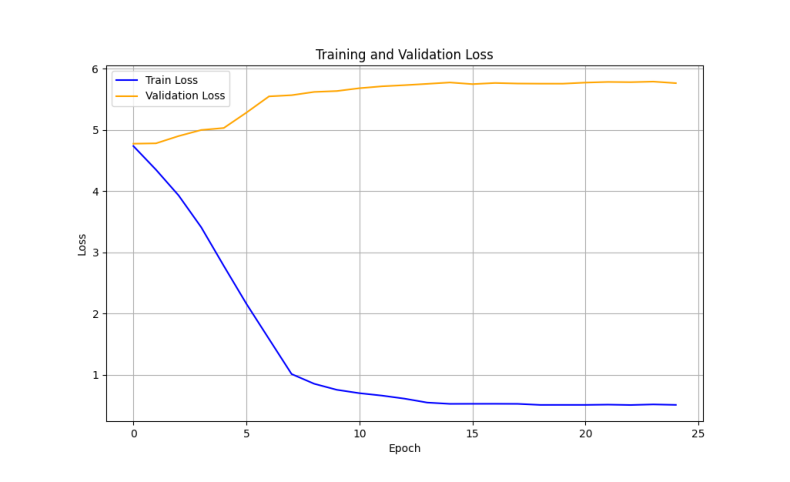